# Dfsu - Export to shapefile

1. Read selected item and timestep from dfsu
2. Extract geometry
3. Create GeoPandas dataframe
4. Save to ESRI shapefile

In [1]:
# conda install geopandas

## Step 1. read the selected data

<AxesSubplot:>

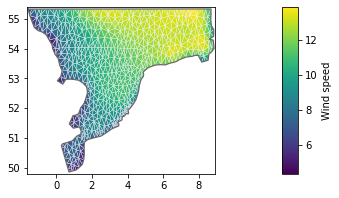

In [1]:
from mikeio import Dfsu

dfsu = Dfsu("../tests/testdata/wind_north_sea.dfsu")
ds = dfsu.read()
ws = ds["Wind speed"][0]
dfsu.plot(ws, label="Wind speed")

## Step 2. extract geometry

In [2]:
shp = dfsu.to_shapely()
type(shp)

shapely.geometry.multipolygon.MultiPolygon

Geopandas does not like multipolygon, it should be a list of polygons

In [3]:
poly_list = [p for p in shp]

C:\Users\JAN\AppData\Local\Temp/ipykernel_12832/173561190.py:1: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  poly_list = [p for p in shp]


## Step 3. Create a geopandas dataframe

In [6]:
import pandas as pd
import geopandas as gpd

df = pd.DataFrame({'wind_speed':ws.to_numpy()})
df.head()

,wind_speed
0,9.530760
1,9.652719
2,9.806072
3,8.775489
4,11.013206


In [7]:
gdf = gpd.GeoDataFrame(df,geometry=poly_list)

## Step 4. Save to shapefile

In [8]:
gdf.to_file("wind_speed.shp")

## Step 5...
Do further work in QGIS

![QGIS](../images/dfsu_qgis.png)

Would you prefer to have this workflow to be a method on the `mikeio.Dfsu` class?

Post an issue on [GitHub](https://github.com/DHI/mikeio/issues) !

# Contour lines

In [8]:
import matplotlib.pyplot as plt

In [9]:
# get coordinates
ec = dfsu.element_coordinates
lon = ec[:,0]
lat = ec[:,1]

In [10]:
# Select item and timestep
m = ds['Wind speed'][0]

In [11]:
# Interpolate to cartesian grid
import numpy as np
from  scipy.interpolate import griddata
numcols, numrows = 200, 200
xi = np.linspace(lon.min(), lon.max(), numcols)
yi = np.linspace(lat.min(), lat.max(), numrows)
xi, yi = np.meshgrid(xi, yi)

grid_z = griddata(points=ec[:,0:2],values=m,xi=(xi,yi),method='cubic')

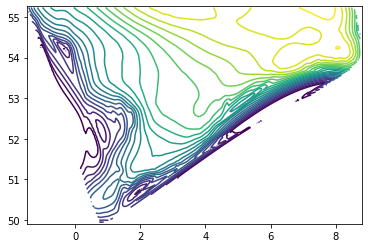

In [12]:
contour_levels=np.arange(4, 14, 0.5)
cn = plt.contour(xi,yi,grid_z,levels=contour_levels)

In [13]:
from shapely.geometry import LineString

poly_list = []

for i in range(len(cn.collections)):
    p = cn.collections[i].get_paths()[0]
    v = p.vertices
    x = v[:,0]
    y = v[:,1]
    poly = LineString([(i[0], i[1]) for i in zip(x,y)])
    if(poly.is_empty):
        print(f"{i} is empty")
    poly_list.append(poly)

In [14]:
# Clip to domain
domain = dfsu.to_shapely().buffer(0)
poly_list = [p.intersection(domain) for p in poly_list]

In [15]:
# Create GeoDataframe
df = pd.DataFrame({'wind_speed':contour_levels})
gdf = gpd.GeoDataFrame(df,geometry=poly_list)
gdf.head()

,wind_speed,geometry
0,4.0,LINESTRING EMPTY
1,4.5,LINESTRING EMPTY
2,5.0,"LINESTRING (0.74084 49.95996, 0.79247 49.94723..."
3,5.5,"LINESTRING (0.74084 50.00444, 0.79247 49.99547..."
4,6.0,"LINESTRING (0.68920 50.08850, 0.73941 50.06993..."


In [16]:
# export shapefile
gdf.to_file("wind_speed_contours.shp")

![QGIS](../images/dfsu_qgis_contours.png)

# Clean up

In [17]:
import os

files = ["wind_speed","wind_speed_contours"]

exts = ["cpg","dbf","shp","shx"]

for file in files:
    for ext in exts:
        filename = f"{file}.{ext}"
        if os.path.exists(filename): os.remove(filename)